In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import mne
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
!pip install gdown

In [3]:
# sub11 MI

!gdown --id 1fTtf0gsszdBz7py04xTbViToRh8YifxT
!gdown --id 11mI4k_qO1qHwwoIELEB3Yx-S8m7PgoBz
!gdown --id 1uP7eNw6_5PGy6kCLoQF3Cpy76Y4TOGzD
# s12
!gdown --id 1EMNrE7j837SLxVWnJRPcSXWYCj4Jbu9Q
!gdown --id 1gOZA9zCb6-5q_2uaCORKkV9sZ9RB6t3u
!gdown --id 1JqQWF3SdihepFZYWpRmVlrX4U7Tlf_HO
# s7
!gdown --id 1riEilHXi9C963kh7I1KPEILD10BFqhqT
!gdown --id 1lCdlMty81aKMDPhxWoUFMPY6K0OAJEWI
!gdown --id 1WJX1gstG3sCx4tpp-zuMD16eySQ84CYw

# s4
!gdown --id 1nw2VTtjG59tTr1W_6DGWxtbB-_Pz-0vK
!gdown --id 1tg1ufwTiUOxKFLvNjJuZswQcYhwzranS
!gdown --id 13IULdWiK1T8x_7XLfl-VWENieIFjK629

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1fTtf0gsszdBz7py04xTbViToRh8YifxT
From (redirected): https://drive.google.com/uc?id=1fTtf0gsszdBz7py04xTbViToRh8YifxT&confirm=t&uuid=876df9ab-9277-47a8-abb1-52ac6cca4827
To: /kaggle/working/session1_sub11_reaching_MI.eeg
100%|███████████████████████████████████████| 1.20G/1.20G [00:08<00:00, 140MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11mI4k_qO1qHwwoIELEB3Yx-S8m7PgoBz
To: /kaggle/working/session1_sub11_reaching_MI.vhdr
100%|██████████████████████████████████████| 16.2k/16.2k [00:00<0

In [4]:
def read_data(path,event_id):
    
    raw = mne.io.read_raw_brainvision(path,eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
    raw.drop_channels(['hEOG_L','hEOG_R','vEOG_U','vEOG_D','EMG_1','EMG_2','EMG_3','EMG_4','EMG_5','EMG_6','EMG_ref'])
    events, event_dict =mne.events_from_annotations(raw)
    epoch=mne.Epochs(raw,events,event_id=event_id,tmin=-0.5,tmax=4,baseline=(-0.5,0))
    
    labels = epoch.events[:,-1]
    data=epoch.get_data()
    
    return data ,labels

In [61]:
s11='/kaggle/working/session1_sub11_reaching_MI.vhdr'
s7='/kaggle/working/session1_sub7_reaching_MI.vhdr'
s4='/kaggle/working/session1_sub4_reaching_MI.vhdr'
s12='/kaggle/working/session1_sub12_reaching_MI.vhdr'
paths=[s11,s12,s7,s4]
event_id=[31,41,51,61]
full_labels=[]
full_data=[]

for path in paths:
    data,labels=read_data(path,event_id)
    full_labels.append(labels)
    full_data.append(data)

full_data=np.vstack(full_data)
full_labels=np.hstack(full_labels)

Extracting parameters from /kaggle/working/session1_sub11_reaching_MI.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 200 events and 11251 original time points ...
0 bad epochs dropped
Extracting parameters from /kaggle/working/session1_sub12_reaching_MI.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14',

In [62]:
full_data.shape

(800, 60, 11251)

In [7]:
import scipy.signal 
from scipy.signal import butter,lfilter

def bandpass(trials, lo, hi, sample_rate):

    a, b = scipy.signal.iirfilter(4, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)],ftype='butter')
    # Applying the filter to each trial
    ntrials = trials.shape[0]
    nchannels=trials.shape[1]
    nsamples=trials.shape[2]
    trials_filt = np.zeros((ntrials,nchannels, nsamples))
    for i in range(ntrials):
        trials_filt[i,:,:] = scipy.signal.filtfilt(a, b, trials[i,:,:], axis=1)
    
    return trials_filt
# final_features=bandpass(final_features,8, 30, sample_rate=1250)

In [8]:
def preprocess_using_wavelet(filtered_signal):  
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 5
    
    # db8,level 5
    # Daubechies sym7
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
    
    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, wavelet)
    return res

In [9]:
def logvar(trials):

    return np.log(np.var(trials, axis=2))

In [10]:
def rolling_mean(arr):
    window_size = 5
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:

        window = arr[i : i + window_size]

        window_average = sum(window) / window_size
        moving_averages.append(window_average)
        
        i += 1
  
    return moving_averages

In [11]:
def compute(epoch):
    new_channels = []
    for channel in epoch:
        new_channel =rolling_mean(channel)
        new_channels.append(new_channel)
    return np.array(new_channels)


###########

def moving_average(trials):
    final_features = []
    for epoch in trials:
        new_epoch = compute(epoch)
        final_features.append(new_epoch)

    final_features = np.array(final_features)
    print(final_features.shape)
    return  final_features

In [12]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import pacf
def compute_statistical(epochs): 
    import pywt
# Assuming your data is stored as epochs with shape (300, 60, 10000)
    # Compute statistical features for each epoch
    statistical_features = []
    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            
#             scales = np.arange(1, 5)
#             wavelet='mexh'
#             coefs, freqs = pywt.cwt(channel,scales,wavelet ) 
#                 coefs,                                 #cwt coefs
#                 acf(channel, nlags=10, method='ywadjusted', alpha=None) #partial autocorrelation
                
            channel_features = [
                
                np.mean(channel),                    # Mean
                np.std(channel),                     # Standard Deviation
                np.var(channel),                     # Variance
                skew(channel),                        # Skewness
                kurtosis(channel),                # Kurtosis
                np.sqrt(np.mean(channel**2)),
                np.mean(channel**2),
                np.max(np.abs(channel)),
                np.ptp(channel),
                np.max(np.abs(channel))/np.sqrt(np.mean(channel**2)),
                np.sqrt(np.mean(channel**2))/np.mean(channel),
                np.max(np.abs(channel))/np.mean(channel),

            ]
            epoch_features.extend(channel_features)
#         epoch_features = np.array(epoch_features)
        statistical_features.append(epoch_features)

    statistical_features = np.array(statistical_features)

    # Print the shape of the computed statistical features
    print("Statistical features shape:", statistical_features.shape)

    return statistical_features

In [13]:
# #  using when computing statistical features
# def preprocessing(raw_data):
    
#     #Normalize min max
#     fe=raw_data
#     normalized_data=(fe - np.min(fe, axis=2, keepdims=True))/ (np.max(fe, axis=2, keepdims=True)-np.min(fe, axis=2, keepdims=True))
#     normalized_data=moving_average(normalized_data)
    
#     idx=0
#     plt.figure(figsize=(7,5))
#     plt.plot(normalized_data[:,0,:][idx])
#     plt.title('Normalized')
#     plt.show()
#     print(normalized_data.shape)
    
#     ttrain=compute_statistical(normalized_data)
#     print(ttrain.shape)
#     return ttrain

In [14]:
# # #  using when computing DWT
# def preprocessing(raw_data):
    
#     fe=raw_data
#     #(trials,channels ,samples)
#     normalized_data=(fe - np.mean(fe, axis=2, keepdims=True))/ np.std(fe, axis=2, keepdims=True)
#     idx=0
#     plt.figure(figsize=(7,5))
#     plt.plot(normalized_data[:,0,:][idx])
#     plt.title('Normalized')
#     plt.show()
#     print(normalized_data.shape)
    
#     #filter
#     lo, hi=8,30
#     filtered_data=bandpass(normalized_data,lo, hi, sample_rate=2500)
    
#     plt.figure(figsize=(7,5))
#     plt.plot(filtered_data[:,0,:][idx])
#     plt.title('Filtered')
#     plt.show()
#     print(filtered_data.shape)
    
#     #DWT
    
#     dwt_data=preprocess_using_wavelet(filtered_data)
    
#     plt.figure(figsize=(7,5))
#     plt.plot(dwt_data[:,0,:][idx])
#     plt.title('DWT')
#     plt.show()
    
#     #logvar
#     res=logvar(dwt_data)

#     return res

In [15]:
# using when computing CSP
def preprocessing(raw_data):
    
    fe=raw_data
    #(trials,channels ,samples)
    normalized_data=(fe - np.mean(fe, axis=2, keepdims=True))/ np.std(fe, axis=2, keepdims=True)

    idx=0
    plt.figure(figsize=(7,5))
    plt.plot(normalized_data[:,0,:][idx])
    plt.title('Normalized')
    plt.show()
    print(normalized_data.shape)

    #filter
    lo, hi=8,30
    filtered_data=bandpass(normalized_data,lo, hi, sample_rate=2500)
    
    
    plt.figure(figsize=(7,5))
    plt.plot(filtered_data[:,0,:][idx])
    plt.title('Filtered')
    plt.show()
    print(filtered_data.shape)

    return filtered_data

In [63]:
len(full_labels)

800

In [64]:
from sklearn.preprocessing import LabelEncoder

lb=LabelEncoder()
full_labels=lb.fit_transform(full_labels)

In [65]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(full_data, full_labels, test_size = 0.2,random_state=40,stratify=full_labels,shuffle=True)

xtrain.shape ,xtest.shape 

((640, 60, 11251), (160, 60, 11251))

In [66]:
ytrain.shape,ytest.shape

((640,), (160,))

In [67]:
late_test1=xtest[16]
late_label1=ytest[16]

late_test2=xtest[25]
late_label2=ytest[25]
late_test1.shape,late_test2.shape,late_label1,late_label2

((60, 11251), (60, 11251), 0, 2)

In [68]:
ytest

array([2, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 2, 0, 3, 1, 3, 3, 2,
       0, 2, 2, 2, 0, 1, 3, 1, 3, 0, 3, 3, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0,
       2, 1, 2, 1, 2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 1, 3, 0, 1, 1, 2, 3, 1,
       2, 0, 3, 0, 1, 3, 2, 3, 0, 0, 2, 3, 3, 0, 3, 3, 2, 0, 1, 0, 2, 1,
       3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 2, 0, 1, 3, 2, 0, 2, 1, 0, 1, 0, 3,
       1, 0, 0, 3, 2, 1, 0, 2, 1, 1, 1, 3, 3, 0, 3, 0, 0, 1, 3, 2, 2, 3,
       1, 3, 2, 2, 0, 3, 0, 1, 2, 3, 2, 0, 1, 3, 3, 1, 2, 3, 3, 0, 1, 1,
       1, 0, 3, 0, 2, 3])

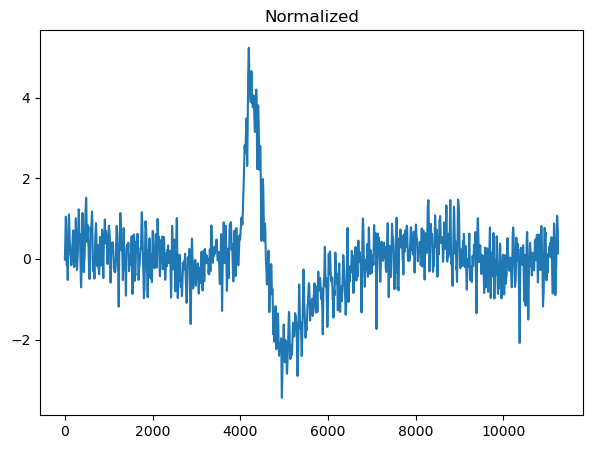

(640, 60, 11251)


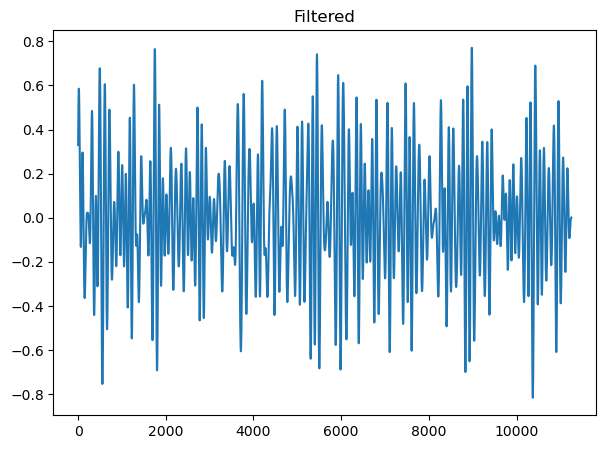

(640, 60, 11251)


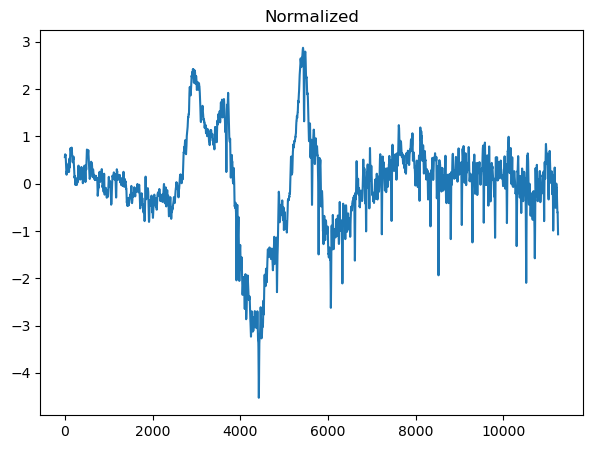

(160, 60, 11251)


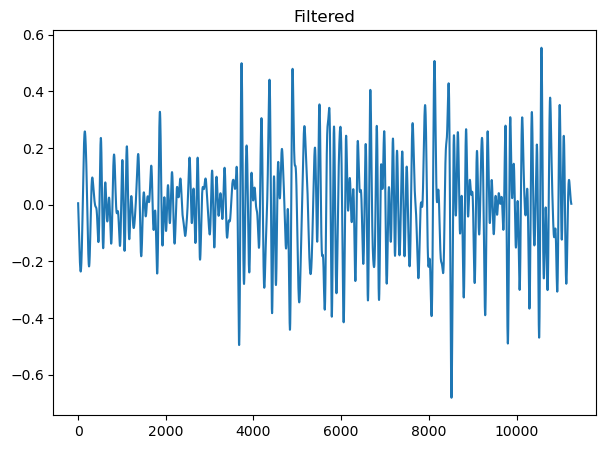

(160, 60, 11251)


In [69]:
xtrain = preprocessing(xtrain)
xtest = preprocessing(xtest)

In [70]:
xtrain.shape , xtest.shape

((640, 60, 11251), (160, 60, 11251))

In [71]:
# #  using when computing statistical features
# from sklearn.decomposition import PCA

# pca=PCA(30)
# xtrain=pca.fit_transform(xtrain)

# xtest=pca.transform(xtest)
# xtrain.shape,xtest.shape

In [72]:
# using when computing CSP
from mne.decoding import CSP

csp = CSP(n_components=60, reg=None, log=True,norm_trace=False)

xtrain = csp.fit_transform(xtrain,ytrain) 
xtest = csp.transform(xtest)

Computing rank from data with rank=None
    Using tolerance 43 (2.2e-16 eps * 60 dim * 3.2e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 44 (2.2e-16 eps * 60 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 45 (2.2e-16 eps * 60 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 44 (2.2e-16 eps * 60 dim * 3.3e+15  max singular value)
    Estimated rank (

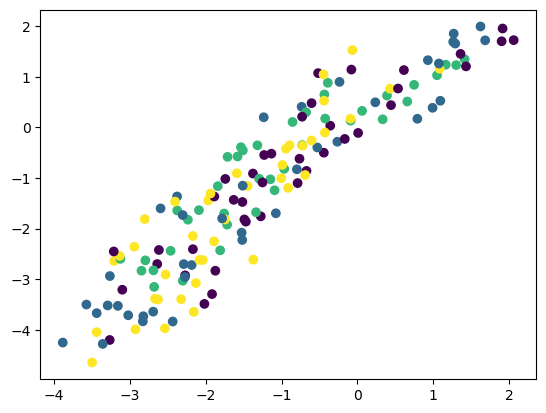

In [77]:
plt.scatter(xtest[:,0],xtest[:,1],c=ytest)

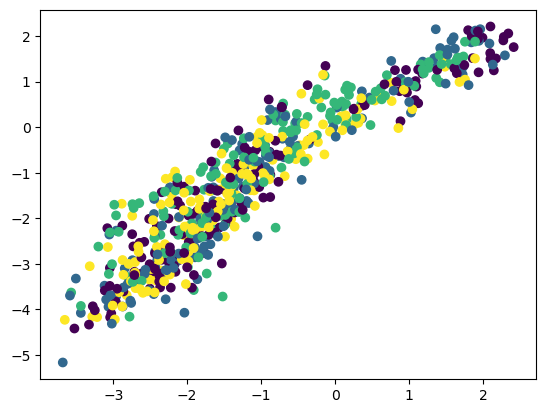

In [78]:
plt.scatter(xtrain[:,0],xtrain[:,1],c=ytrain)

In [79]:
from sklearn.utils import shuffle
xtrain,ytrain=shuffle(xtrain,ytrain,random_state=2)

In [80]:
ytrain

array([3, 0, 0, 3, 0, 0, 0, 2, 1, 3, 3, 0, 2, 1, 2, 3, 0, 0, 2, 0, 2, 1,
       0, 0, 0, 1, 3, 0, 1, 1, 2, 1, 0, 1, 0, 3, 1, 3, 0, 3, 3, 1, 3, 3,
       3, 3, 0, 1, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 1, 3, 3, 2, 1, 1, 2,
       0, 0, 2, 3, 1, 1, 1, 0, 3, 2, 0, 0, 3, 2, 2, 0, 0, 3, 1, 3, 2, 3,
       3, 1, 1, 3, 2, 2, 2, 1, 2, 3, 2, 2, 0, 1, 3, 1, 1, 3, 1, 2, 2, 0,
       0, 3, 2, 0, 1, 2, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 3, 2, 0, 3, 2, 2,
       0, 1, 2, 3, 3, 1, 1, 0, 1, 2, 0, 0, 2, 3, 1, 0, 2, 0, 2, 2, 1, 1,
       1, 2, 2, 1, 2, 0, 0, 1, 3, 0, 0, 1, 0, 3, 0, 0, 1, 3, 2, 3, 1, 1,
       0, 3, 0, 1, 0, 3, 3, 3, 2, 3, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 3, 3,
       2, 3, 0, 1, 0, 1, 0, 1, 0, 0, 2, 3, 1, 3, 3, 2, 1, 3, 0, 2, 0, 0,
       0, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 1, 3, 3, 3, 2, 3, 2, 3,
       3, 3, 3, 0, 2, 2, 3, 3, 3, 0, 0, 3, 1, 3, 2, 0, 2, 3, 3, 2, 3, 0,
       0, 2, 2, 1, 3, 1, 2, 1, 3, 2, 3, 0, 1, 0, 0, 3, 3, 2, 0, 1, 1, 1,
       3, 3, 1, 1, 1, 1, 3, 2, 3, 0, 2, 2, 3, 3, 1,

# Logistic Regression

Accuracy: 0.50625


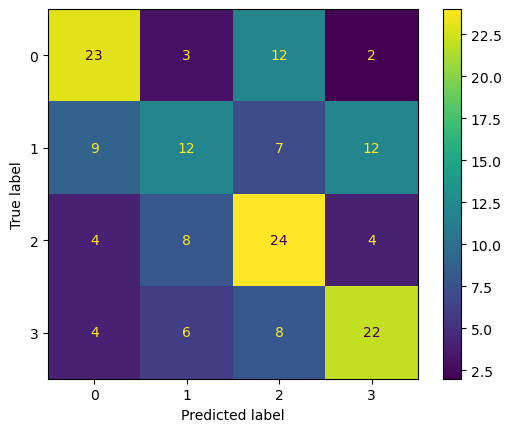

In [81]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix

#Create a svm Classifier
clf = LogisticRegression()# Linear Kernel

#Train the model using the training sets
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


### SVM

Accuracy: 0.5


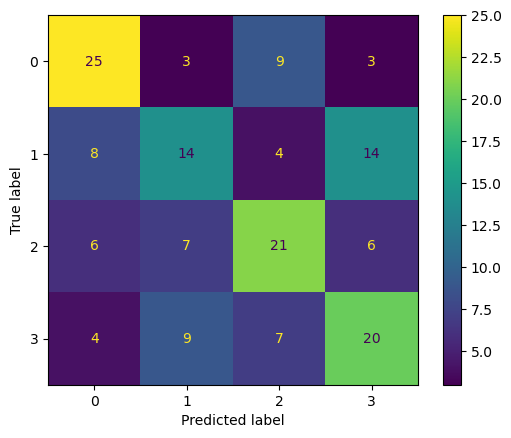

In [86]:
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


# SVM Muliti class1

Accuracy: 0.53125


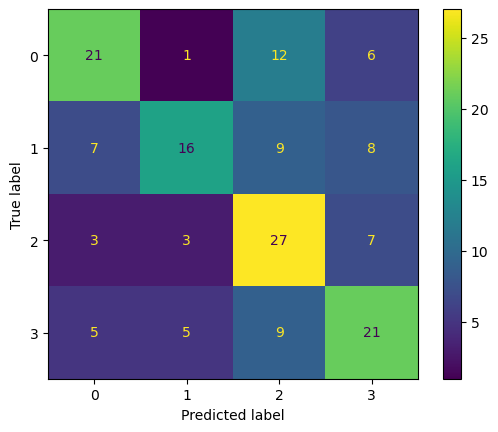

In [90]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
#Create a svm Classifier
clf = svm.SVC(kernel='poly') # Linear Kernel

ovr=OneVsRestClassifier(clf)
#Train the model using the training sets
ovr.fit(xtrain, ytrain)

y_pred = ovr.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# SVM Muliti class2

Accuracy: 0.50625


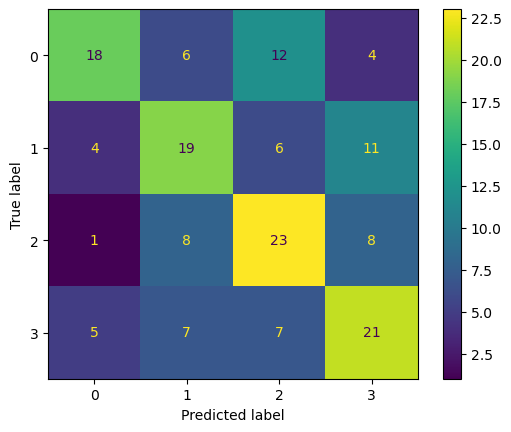

In [94]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

ovo=OneVsOneClassifier(clf)
#Train the model using the training sets
ovo.fit(xtrain, ytrain)

y_pred = ovo.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# MLP

Accuracy: 0.55


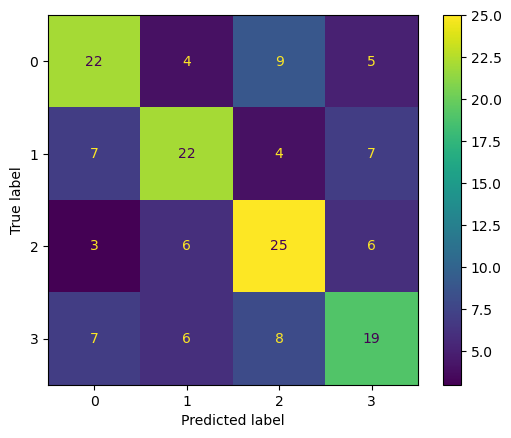

In [95]:
from sklearn.neural_network import MLPClassifier

clf=MLPClassifier( hidden_layer_sizes=(128),max_iter=1000)#max 42%

#Train the model using the training sets
clf.fit(xtrain, ytrain)


y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# LDA

Accuracy: 0.5125


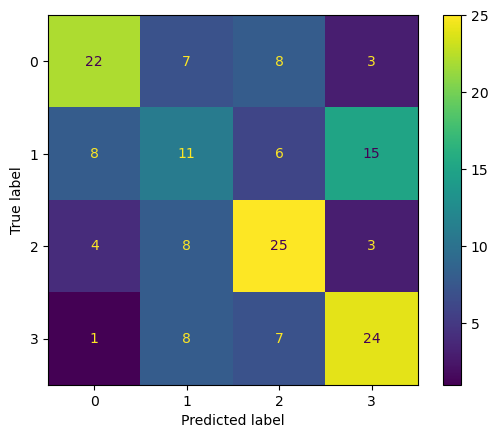

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='svd')#'lsqr', 'eigen'

#Train the model using the training sets
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# KNN

Accuracy: 0.45


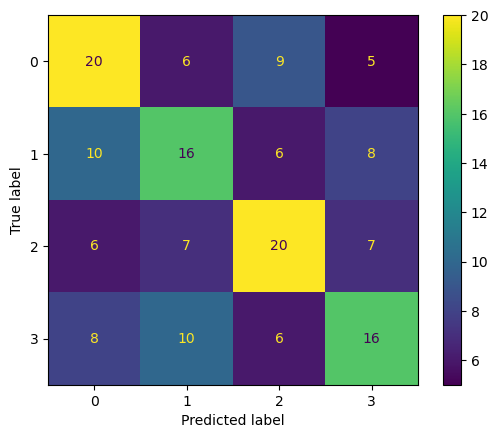

In [98]:
from sklearn.neighbors import KNeighborsClassifier

clf=KNeighborsClassifier(n_neighbors=7)
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# Naive

Accuracy: 0.36875


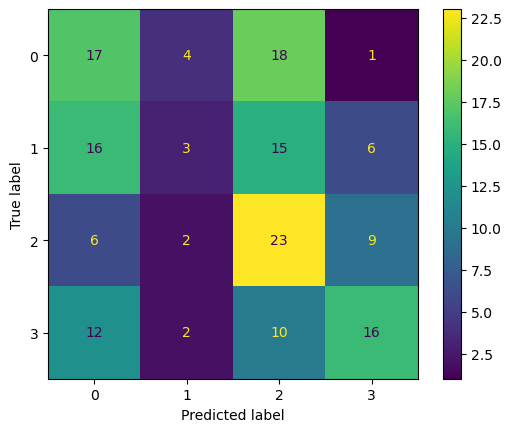

In [99]:
from sklearn import naive_bayes

clf=naive_bayes.GaussianNB()

clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Decision Tree

Accuracy: 0.39375


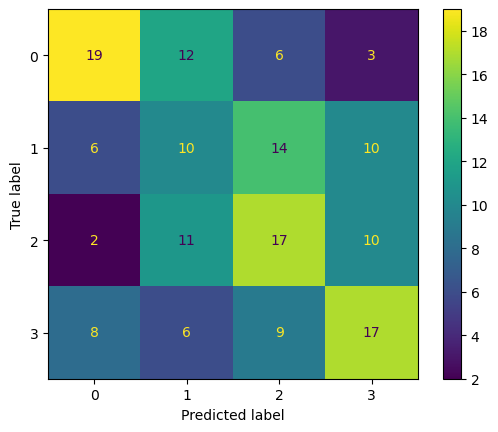

In [101]:
#changing hyperparameters will reduce overfitting
# Training the model
clf = DecisionTreeClassifier(max_depth = 20)
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# Random Forest  

Accuracy: 0.45


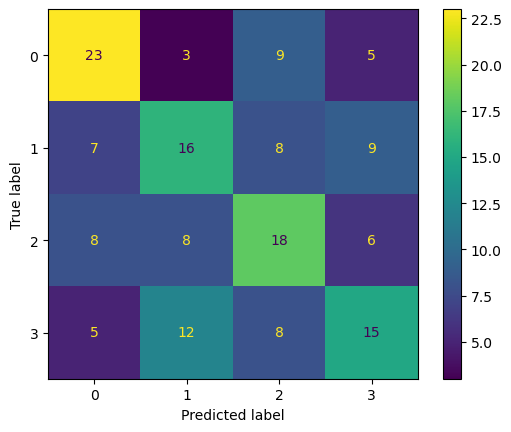

In [102]:
# Training the model
# clf = RandomForestClassifier(n_estimators=15,max_depth=11,random_state=39)#70
# clf = RandomForestClassifier(n_estimators=9,max_depth=11,random_state=39) #86(11,61)
# clf = RandomForestClassifier(n_estimators=10,max_depth=10,random_state=37) #70 (11,21)
# clf = RandomForestClassifier(n_estimators=15,max_depth=7,random_state=41) #63(31,41)
# clf = RandomForestClassifier(n_estimators=15,max_depth=7,random_state=31) #73(51,61)
# clf = RandomForestClassifier(n_estimators=15,max_depth=7,random_state=29) #76 (11,31)
# clf = RandomForestClassifier(n_estimators=15,max_depth=7,random_state=29) #66 (11,41) 
clf = RandomForestClassifier(n_estimators=15,max_depth=25) #77 (11,51) 
# clf = RandomForestClassifier(n_estimators=15,max_depth=10,random_state=38) 

clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)

cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


# Adaboost

Accuracy: 0.5125


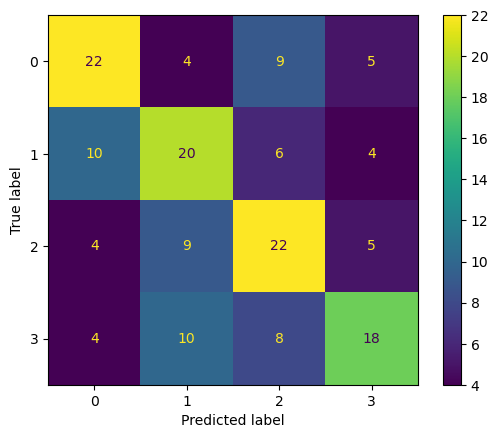

In [103]:
#Training the model
clf=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=15)
# n_estimators: number of our weak learners
# base_estimator: model used for weak learners
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


# LSTM 

In [104]:
X_train=xtrain
X_test=xtest
X_train.shape,xtrain.shape

((640, 60), (640, 60))

In [105]:
import tensorflow as tf
def build_model(num_classes):

#     inputs = tf.keras.Input(shape=(X_train.shape[1],X_train.shape[2]))
# #     x = tf.keras.layers.Reshape((-1, 60))(inputs)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
#     x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(64)(x)
    inputs = tf.keras.Input(shape=(None, X_train.shape[1]))
    x = tf.keras.layers.Reshape((-1, X_train.shape[1]))(inputs)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [109]:
user_model = build_model(num_classes=4)
Epochs=300
checkpoint_path="weights_lstm.best.hdf5"
check_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,monitor='val_accuracy' ,save_weights_only=True, verbose=1)

user_history = user_model.fit(
    X_train,
    ytrain,
    epochs=Epochs,           
    batch_size=64,
    validation_data=(X_test,ytest)
,callbacks=[check_point])

Epoch 1/300
 9/10 [==========================>...] - ETA: 0s - loss: 1.3864 - accuracy: 0.2517
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to weights_lstm.best.hdf5
10/10 [==============================] - 11s 285ms/step - loss: 1.3864 - accuracy: 0.2547 - val_loss: 1.3858 - val_accuracy: 0.2500
Epoch 2/300
 9/10 [==========================>...] - ETA: 0s - loss: 1.3853 - accuracy: 0.2604
Epoch 2: val_accuracy improved from 0.25000 to 0.29375, saving model to weights_lstm.best.hdf5
10/10 [==============================] - 0s 40ms/step - loss: 1.3849 - accuracy: 0.2734 - val_loss: 1.3826 - val_accuracy: 0.2937
Epoch 3/300
 9/10 [==========================>...] - ETA: 0s - loss: 1.3744 - accuracy: 0.3611
Epoch 3: val_accuracy improved from 0.29375 to 0.37500, saving model to weights_lstm.best.hdf5
10/10 [==============================] - 0s 41ms/step - loss: 1.3710 - accuracy: 0.3625 - val_loss: 1.3547 - val_accuracy: 0.3750
Epoch 4/300
 9/10 [======================

5/5 [==============================] - 2s 10ms/step
Accuracy: 0.575


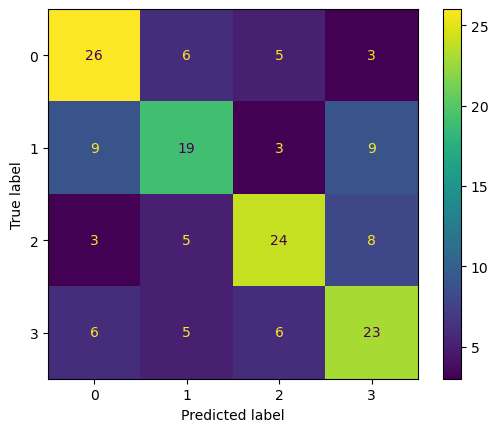

In [110]:
user_model.load_weights('/kaggle/working/weights_lstm.best.hdf5')
y_pred = user_model.predict(X_test)

y_pred=[np.argmax(v) for v in y_pred]
print("Accuracy:",accuracy_score(ytest, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix

cm=confusion_matrix(ytest, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# Final Testing 

In [111]:
late_test1.shape,late_test2.shape,late_label1,late_label2

((60, 11251), (60, 11251), 0, 2)

In [113]:
def do_test(late_test1,late_label1):

    print(late_test1.shape)
    late_testx = preprocessing(np.expand_dims(late_test1,axis=0))
    late_testx=csp.transform(late_testx)
    print(late_testx.shape)

#     pred=clf.predict(late_testx)

    pred = user_model.predict(late_testx)

    pred=[np.argmax(v) for v in pred]

    

    if  pred==late_label1:
        print(f'Success {pred} == {late_label1}')
    else:
        print(f'Fail {pred} != {late_label1}')

(60, 11251)


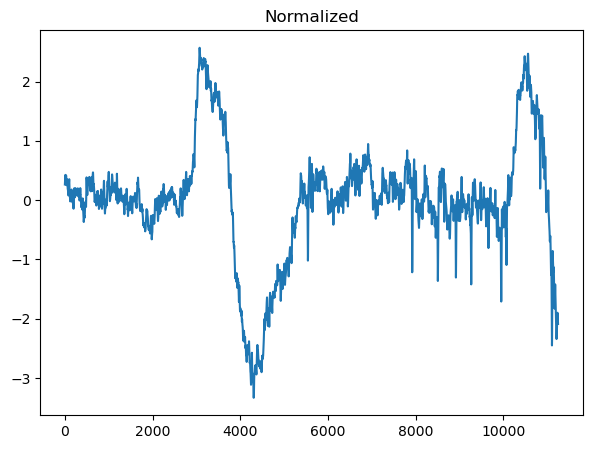

(1, 60, 11251)


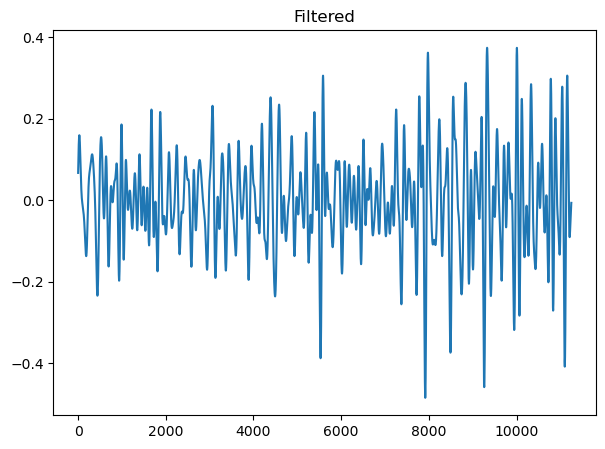

(1, 60, 11251)
(1, 60)
1/1 [==============================] - 2s 2s/step
Success [0] == 0


In [114]:
do_test(late_test1,late_label1)

(60, 11251)


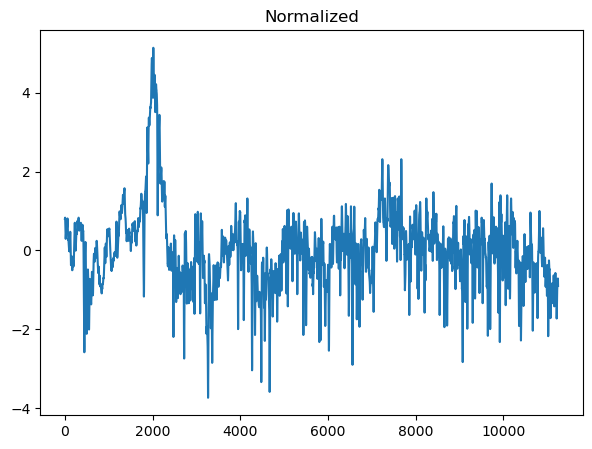

(1, 60, 11251)


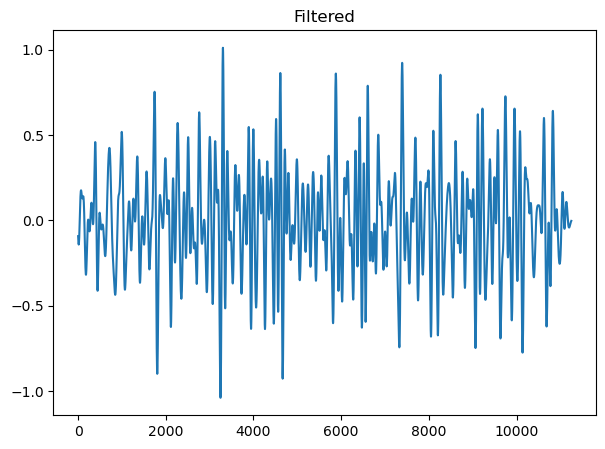

(1, 60, 11251)
(1, 60)
1/1 [==============================] - 0s 46ms/step
Success [2] == 2


In [115]:
do_test(late_test2,late_label2)